## System Models

In [35]:
import autograd.numpy as np
from autograd import jacobian, grad
from scipy.linalg import logm
import matplotlib.pyplot as plt

class VanDerPol(object):
    """
    2D dynamics describing the van der pol osciallator
    """
    def __init__(self, eps:float=1.0, dt:float=0.01):
        self.name = "VanDerPol"
        self.eps = eps 
        self.dt = dt
        self.dfdx = jacobian(self.dynamics, argnum=0)
        self.num_states = 2
        self.reset()

    def reset(self):
        self.state = np.random.uniform(-3., 3., size=(self.num_states,))
        return self.state.copy()

    def dynamics(self, x):
        xdot = np.array([
            x[1],
            -x[0] + self.eps * (1 - x[0]**2) * x[1]
        ])
        return xdot

    def step(self):
        k1 = self.dt * self.dynamics(self.state)
        k2 = self.dt * self.dynamics(self.state + k1/2.)
        k3 = self.dt * self.dynamics(self.state + k2/2.)
        k4 = self.dt * self.dynamics(self.state + k3)

        self.state = self.state + (1/6.) * (k1+2.0*k2+2.0*k3+k4)
        return self.state.copy()

class ContinuousLinearSystem(object):
    """
    2D diagonal, stable linear dynamics (easy easy easy)
    """
    def __init__(self, dt:float=0.01):
        self.name = "LinearSystem"
        self.dt = dt
        self.dfdx = jacobian(self.dynamics, argnum=0)
        self.num_states = 2
        self.reset()
        self.evals = [np.exp(-1*dt), np.exp(-2*dt)]  # eigenvalues of the discretized system

    def reset(self):
        self.state = np.random.uniform(-15., 15., size=(self.num_states,))
        return self.state.copy()

    def dynamics(self, x):
        xdot = np.array([
            -x[0] + x[1],
            -2*x[1]
        ])
        return xdot

    def step(self):
        k1 = self.dt * self.dynamics(self.state)
        k2 = self.dt * self.dynamics(self.state + k1/2.)
        k3 = self.dt * self.dynamics(self.state + k2/2.)
        k4 = self.dt * self.dynamics(self.state + k3)

        self.state = self.state + (1/6.) * (k1+2.0*k2+2.0*k3+k4)
        return self.state.copy()
    
class DiscreteLinearSystem(object):
    """
    Discrete 2D dynamics (the simplest system of all time)
    """
    def __init__(self, dt:float=0.01): 
        self.name = "LinearSystem"
        self.dt = dt
        self.num_states = 2
        self.reset()
        self.evals = [0.5, -0.75]

    def reset(self):
        self.state = np.random.uniform(-3., 3., size=(self.num_states,))
        return self.state.copy()

    def dynamics(self, x):
        """
        For this system, A = diag{eval_1, eval_2}
        """
        x_new = np.array([
            self.evals[0]*x[0],
            self.evals[1]*x[1]
        ])
        return x_new

    def step(self):
        self.state = self.dynamics(self.state)
        return self.state.copy()

## Choose model

In [36]:
model = DiscreteLinearSystem()

## Define dictionaries of observables

In [37]:
class Observables(object):
    
    def __init__(self, choice=0, order=0, cross_terms=False):
        self.choice = choice
        self.order = order
        self.cross_terms = cross_terms

    def handmade(self, x):
        if self.choice == 1:
            lift = np.array([
                x[0],
                x[1],
                x[0]**2,
                x[1]**2,
                x[0]*x[1],
                x[0]**3,
                x[1]**3,
                (x[0]**2)*x[1],
                (x[1]**2)*x[0]
            ])

        if self.choice == 2:
            lift = np.array([
                x[0],
                x[1],
                x[0]**2,
                x[1]**2,
                x[0]*x[1]
            ])

        if self.choice == 3:
            lift = np.array([
                x[0],
                x[1],
                x[0]*x[1]
            ])

        if self.choice == 4:
            lift = np.array([
                x[0]**2,
                x[1]**2,
                x[0]*x[1],
                x[0]**3,
                x[1]**3,
                (x[0]**2)*x[1],
                (x[1]**2)*x[0]
            ])

        if self.choice == 5:
            lift = np.array([
                np.sin(x[0]),
                np.sin(x[1]),
                np.cos(x[0]),
                np.cos(x[1])
            ])

        if self.choice == 6:
            lift = np.array([
                x[0],
                x[1],
                np.exp(x[0]),
                np.exp(x[1])
            ])

        return lift

    def poly(self, x):
        # make polynomial functions up to order n
        polys = {}
        for n in range(self.order):
            polys[n] = lambda a: a**(n+1)
        
        lift = np.zeros(2*self.order)
        for m in range(self.order):
            lift[2*m] = polys[m](x[0])
            lift[1 + 2*m] = polys[m](x[1])

        if self.cross_terms:
            iter = 0
            lift_cross_terms = np.zeros(self.order**2)
            for j in range(self.order):
                for i in range(self.order):
                    lift_cross_terms[iter] = polys[j](x[0])*polys[i](x[1])
                    iter += 1
            lift = np.insert(lift_cross_terms, 0, lift)
        return lift
    
    def higher_derivative(func, order):
        for i in range(order):
            func = grad(func)
        return func

    def hermite(self, x):
        # make Hermitian polynomials
        polys = {}
        deriv_func = lambda v: np.exp(-0.5*v**2)
        for n in range(self.order):
            deriv_term = self.higher_derivative(deriv_func, n)
            polys[n] = lambda a: (-1.)**n * np.exp(0.5*a**2) * deriv_term(a)

        lift = np.zeros(2*self.order)
        for m in range(self.order):
            lift[2*m] = polys[m](x[0])
            lift[1 + 2*m] = polys[m](x[1])

        if self.cross_terms:
            iter = 0
            lift_cross_terms = np.zeros(self.order**2)
            for j in range(self.order):
                for i in range(self.order):
                    lift_cross_terms[iter] = polys[j](x[0])*polys[i](x[1])
                    iter += 1
            lift = np.insert(lift_cross_terms, 0, lift)

        return lift

## Collect trajectory data and compute EDMD/ResDMD

size of dictionary:  5


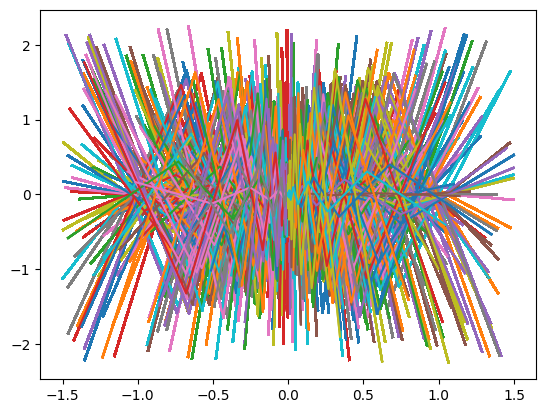

In [40]:
np.random.seed(420) # set the seed for reproducibility 
num_trials = 500 # number of resets
tf = 3
horizon = int(tf/model.dt) # how long we simulate the system for
M = num_trials * horizon # M sized data

traj = np.zeros([2, horizon, num_trials])

### Choose basis functions ###
obs_choice = 2 # if handmade basis is used
order = 1 # if (hermitian) polynomials are used
cross_terms = True

obs = Observables(obs_choice, order, cross_terms)
z = obs.handmade # choose which basis functions you want to use

num_obs = len(z(model.reset()))
print("size of dictionary: ", num_obs)

# EDMD matrices
A = np.zeros((num_obs, num_obs))
G = np.zeros((num_obs, num_obs))
L = np.zeros((num_obs, num_obs))

for k in range(num_trials):
    xt = model.reset()
    for t in range(horizon):
        xt_new = model.step()
        traj[:, t, k] = xt_new
 
        A += np.outer(z(xt_new), z(xt))
        G += np.outer(z(xt), z(xt))
        L += np.outer(z(xt_new), z(xt_new))

    plt.plot(traj[0], traj[1]) # plot trajectories used for
A /= M
G /= M
L /= M

koopman = np.dot(A, np.linalg.pinv(G))
cont_koopman = logm(koopman)/model.dt

## Compute the residual, as defined in Matthew Colbrook's ResDMD

In [41]:
evals, evecs = np.linalg.eig(koopman)
residuals = np.zeros(len(evals))

for i in range(len(evals)):
    evec_mat = np.asmatrix(evecs[:,i]).T
    lam = evals[i]
    numer = evec_mat.H@(L - lam*A.T - np.conj(lam)*A + np.absolute(lam)**2*G)@evec_mat
    denom = evec_mat.H@G@evec_mat
    residuals[i] = np.sqrt(np.real(numer[0,0])/np.real(denom[0,0]))

for i, eval in enumerate(evals):
    print("|eval|: ", np.absolute(eval), ".......... res: ", residuals[i])

if model.name == "LinearSystem":
    # compute error between estimate eigenvalues and known eigenvalues
    # and compare to residual
    for i, eval in enumerate(evals):
        a = np.abs(eval - model.evals[0])
        b = np.abs(eval - model.evals[1])
        print(min([a,b]))
        print("Is residual faithful? ", min([a,b]) < residuals[i])

|eval|:  0.0033333333333327958 .......... res:  0.033166247903551924
|eval|:  0.004285714285713076 .......... res:  0.03904471533918687
|eval|:  0.0011111111111116337 .......... res:  0.014865653511401084
|eval|:  0.0014285714285716964 .......... res:  0.0654497782226072
|eval|:  0.0009090909090907035 .......... res:  0.023337268459985662
0.4966666666666672
Is residual faithful?  False
0.49571428571428694
Is residual faithful?  False
0.4988888888888884
Is residual faithful?  False
0.5014285714285717
Is residual faithful?  False
0.5009090909090907
Is residual faithful?  False
